In [1]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [3]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]
                
        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "header": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

In [4]:

competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

100%|██████████| 64/64 [00:19<00:00,  3.24it/s]


In [5]:
df

,x,y,header,phase,outcome,statsbomb_xg
0,115.0,34.0,0,Open Play,1,0.074087
1,112.0,36.0,0,Open Play,1,0.292995
2,101.0,55.0,0,Free Kick,0,0.078714
3,103.0,24.0,0,Open Play,0,0.028038
4,96.0,37.0,0,Open Play,0,0.064261
...,...,...,...,...,...,...
1701,93.0,27.0,0,Free Kick,0,0.060391
1702,106.0,60.0,0,Open Play,0,0.027727
1703,93.0,43.0,0,Open Play,0,0.020467
1704,96.0,34.0,0,Free Kick,0,0.088615


In [6]:
df.x = df.x / 120 * 105
df.y = df.y / 80 * 68

In [7]:
df['distance'] = np.sqrt((df.x - 105)**2 + (df.y - 34)**2)
right_post = np.sqrt((df.x - 105)**2 + (df.y - (34 + 7.32/2))**2)
left_post = np.sqrt((df.x - 105)**2 + (df.y - (34 - 7.32/2))**2)
df['angle'] = np.arccos((right_post**2 + left_post**2 - 7.32**2) / (2 * right_post * left_post))

In [8]:
#df['angle'] = np.abs(np.arcsin((7.32) / df.distance) * 180 / np.pi)

In [9]:
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]

In [10]:
shots = shots[shots.header == 1]

In [11]:
shots

,x,y,header,phase,outcome,statsbomb_xg,distance,angle
11,100.625,33.15,1,Open Play,0,0.188826,4.456807,1.371524
21,98.875,26.35,1,Open Play,0,0.057968,9.799904,0.497080
47,91.000,33.15,1,Open Play,0,0.013532,14.025780,0.509728
51,98.875,43.35,1,Open Play,0,0.020663,11.177572,0.382190
59,93.625,40.80,1,Open Play,0,0.054655,13.252571,0.474181
...,...,...,...,...,...,...,...,...
1692,97.125,49.30,1,Open Play,0,0.007516,17.207720,0.201144
1694,103.250,39.95,1,Open Play,0,0.086920,6.202016,0.472394
1699,98.000,34.00,1,Open Play,0,0.055357,7.000000,0.963531
1700,92.750,34.00,1,Open Play,0,0.016941,12.250000,0.580666


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(shots[['distance', 'angle']], shots.outcome)


#model = LogisticRegression()

#model.fit(shots[['distance', 'angle']], shots.outcome)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [29]:
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [16]:
model.score(shots[['distance', 'angle']], shots.outcome)

0.896774193548387

In [24]:
model.named_steps['logisticregression'].intercept_, model.named_steps['logisticregression'].coef_

(array([-2.50728236]), array([[-0.7929128,  0.226228 ]]))

In [25]:
predictions = model.predict_proba(shots[['distance', 'angle']])[:, 1]

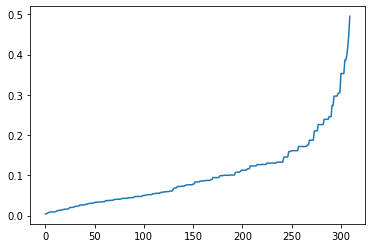

In [26]:
plt.plot(sorted(predictions))

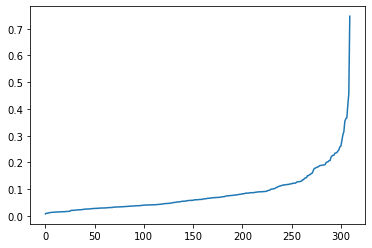

In [27]:
plt.plot(sorted(shots.statsbomb_xg))

In [28]:
sorted(predictions, reverse=True)

[0.4955161824681406,
 0.44996329572108024,
 0.4201040647956825,
 0.3985392224170133,
 0.3867106886603901,
 0.3867106886603899,
 0.35307360071630034,
 0.35307360071630034,
 0.3530736007163001,
 0.352514745529468,
 0.3051600147962802,
 0.3051600147962802,
 0.30314667110183163,
 0.2969096920338984,
 0.2969096920338983,
 0.2969096920338983,
 0.2969096920338983,
 0.27360446133490807,
 0.27360446133490807,
 0.24575225553232083,
 0.24575225553232083,
 0.2457522555323203,
 0.23931204333688494,
 0.23931204333688494,
 0.23931204333688494,
 0.23931204333688494,
 0.23931204333688488,
 0.22616512008645578,
 0.22616512008645578,
 0.22616512008645578,
 0.22616512008645578,
 0.22616512008645573,
 0.22616512008645573,
 0.21047776351969366,
 0.21047776351969366,
 0.21047776351969366,
 0.21047776351969366,
 0.18728615932877474,
 0.18728615932877474,
 0.18728615932877474,
 0.18728615932877474,
 0.18728615932877474,
 0.17544350587190663,
 0.17544350587190663,
 0.17175805749905793,
 0.17175805749905793,
 0.